In [20]:
import os


# Torch
import torch

# Tensordict modules
from tensordict import TensorDict
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# Dragon Env
from gym_dragon.dragon import MiniDragonBaseEnv
from gym_dragon.core import Region, Agent, Tool, Bomb
from gym_dragon.wrappers import MiniObs

In [21]:
# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device  # The device where the simulator is run (VMAS can run on GPU)

# Sampling
frames_per_batch = 6_000  # Number of team frames collected per training iteration
n_iters = 15  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 30  # Number of optimization steps per training iteration
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss

In [22]:
max_steps = 100  # Episode steps before done
num_vmas_envs = (
    frames_per_batch // max_steps
)  # Number of vectorized envs. frames_per_batch should be divisible by this number
scenario_name = "navigation"
n_agents = 5

env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,  # VMAS supports both continuous and discrete actions
    max_steps=max_steps,
    device=vmas_device,
    # Scenario kwargs
    n_agents=n_agents,  # These are custom kwargs that change for each VMAS scenario, see the VMAS repo to know more.
)

In [23]:
class Args:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
        self.round_id = 0


default_actions = np.zeros((n_agents, 9))
default_values = {
    "save_path": "RL/data",
    "seed": 0,
    "tool_per_agent": 2,
    "max_steps": 30,
    "actions": default_actions,
}

args = Args(**default_values)

In [24]:
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path, exist_ok=True)

    **Action Space**

    The environment uses a discrete action space, with actions consisting of the following:

    * Action.unfreeze_agents
        Unfreeze agents at the current node
    * Action.inspect_bomb
        Inspect a bomb at the current node
    * Action.find_next_bomb
        Update the agent's observation with the next bomb in the current node
    * Action.place_bomb_beacon
        Place a bomb beacon at the current node
    * Action.place_help_beacon
        Place a help beacon at the current node
    * Action.remove_bomb_beacon
        Remove a bomb beacon from the current node
    * Action.remove_help_beacon
        Remove a help beacon from the current node
    * Action.go_to(node_id)
        Move the agent to the specified node
    * Action.use_tool(tool)
        Apply the specified tool to the current node

    **Observation Space**

    A standard observation for each agent contains the following items:

    * 'agents'
        An array of shape (num_agents, num_agent_features)
    * 'graph'
        An array of shape (num_nodes, num_node_features)
    * 'action_mask'
        An array of shape (num_actions,)

    See **gym_dragon.core.observation** module for more detail.

In [25]:
class CustomDragonEnv(MiniDragonBaseEnv):
    def __init__(self, agents, **kwargs):
        self._agents = agents  # Set the agents attribute before calling super
        super().__init__(**kwargs)  # Ensure all kwargs are passed to the base class

    @property
    def agents(self):
        return self._agents

    @agents.setter
    def agents(self, value):
        self._agents = value

    @property
    def observation_spec(self):
        # Define observation_spec
        return {"agents": {"observation": torch.zeros((len(self.agents), 36))}}

    def reset(self, **kwargs):
        # Call the parent class's reset method
        raw_obs = super().reset(**kwargs)
        # Convert raw_obs to TensorDict
        obs = TensorDict(
            {
                "agents": {
                    "observation": torch.stack(
                        [torch.tensor(raw_obs[agent]) for agent in self._agents]
                    )
                }
            },
            batch_size=[len(self._agents)],
            device=torch.device("cpu"),
        )
        return obs

    def step(self, actions):
        obs, reward, done, info = super().step(actions)
        return obs, reward, done, info

In [26]:
# Dragon Env actions are Discrete(9)
agents = ["alpha", "bravo", "charlie"]
env = CustomDragonEnv(
    agents=agents,
    mission_length=999,
    recon_phase_length=0,
    include_chained_bombs=False,
    include_fire_bombs=False,
    include_fuse_bombs=False,
    color_tools_only=True,
    obs_wrapper=MiniObs,
)
env.seed(args.seed)
if args.tool_per_agent == 2:
    env.reset(
        csv_path=None,
        num_bombs_per_region=5,
        start_location=None,
        start_regions=set(Region.village),
        tool_allocation={
            "alpha": {Tool.red: 99, Tool.green: 99},
            "bravo": {Tool.blue: 99, Tool.green: 99},
            "charlie": {Tool.red: 99, Tool.blue: 99},
        },
    )
else:
    env.reset(
        csv_path=None,
        num_bombs_per_region=5,
        start_location=None,
        start_regions=set(Region.village),
        tool_allocation={
            "alpha": {Tool.red: 99},
            "bravo": {Tool.green: 99},
            "charlie": {Tool.blue: 99},
        },
    )

In [27]:
env.get_agent_ids()
# env.render()
Action = env.action_enum
obs = env._get_obs()

In [28]:
obs["alpha"].shape

(36,)

In [29]:
# obs, rewards, done, info = env.step(actions=None)

In [30]:
# env = TransformedEnv(
#     env,
#     RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
# )

In [31]:
# n_rollout_steps = 3
# rollout = env.rollout(n_rollout_steps)
# print("rollout of three steps:", rollout)
# print("Shape of the rollout TensorDict:", rollout.batch_size)

In [32]:
share_parameters_policy = True

policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs=36,
        n_agent_outputs=9,
        n_agents=len(env.agents),
        centralised=False,  # the policies are decentralised (ie each agent will act from its observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    ),
    NormalParamExtractor(),  # Rm for discrete actions
)

In [33]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)

In [34]:
policy = ProbabilisticActor(
    module=policy_module,
    # spec=env.unbatched_action_spec,
    in_keys=[("agents", "loc"), ("agents", "scale")],
    out_keys=[("agents", "actions")],
    distribution_class=TanhNormal,
    # distribution_kwargs={
    #     "min": env.unbatched_action_spec[env.action_key].space.low,
    #     "max": env.unbatched_action_spec[env.action_key].space.high,
    # },
    return_log_prob=True,
    log_prob_key=("agents", "sample_log_prob"),
)  # we'll need the log-prob for the PPO loss

In [35]:
# Reset environment and print initial state
state = env.reset()
print("Initial state:", state)

# Convert state to the required format
state_tensor = state["agents"]["observation"].to(device)

# Prepare state dictionary
state_dict = TensorDict(
    {"agents": {"observation": state_tensor}}, batch_size=[len(agents)], device=device
)
print("State TensorDict:", state_dict)

import torch.nn as nn


# Define a dummy policy for testing
class DummyPolicy(nn.Module):
    def forward(self, x):
        logits = torch.randn(x["agents"]["observation"].shape[0], 9, device=device)
        return {"action": logits}


# policy = DummyPolicy().to(device)

# Test policy forward pass
try:
    policy_output = policy(state_dict)
    print("Policy Output:", policy_output)
except Exception as e:
    print("Error during policy forward pass:", e)

Initial state: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                observation: Tensor(shape=torch.Size([3, 36]), device=cpu, dtype=torch.float64, is_shared=False)},
            batch_size=torch.Size([3]),
            device=cpu,
            is_shared=False)},
    batch_size=torch.Size([3]),
    device=cpu,
    is_shared=False)
State TensorDict: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                observation: Tensor(shape=torch.Size([3, 36]), device=cuda:0, dtype=torch.float64, is_shared=True)},
            batch_size=torch.Size([3]),
            device=cuda:0,
            is_shared=True)},
    batch_size=torch.Size([3]),
    device=cuda:0,
    is_shared=True)
Error during policy forward pass: mat1 and mat2 must have the same dtype, but got Double and Float


In [15]:
share_parameters_critic = True
mappo = True  # IPPO if False

critic_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
    n_agent_outputs=1,  # 1 value per agent
    n_agents=len(env.agents),
    centralised=mappo,
    share_params=share_parameters_critic,
    device=device,
    depth=2,
    num_cells=256,
    activation_class=torch.nn.Tanh,
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "state_value")],
)

AttributeError: 'CustomDragonEnv' object has no attribute 'observation_spec'

In [52]:
collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

In [53]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  # We store the frames_per_batch collected at each iteration
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,  # We will sample minibatches of this size
)

In [54]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
)
loss_module.set_keys(  # We have to tell the loss where to find the keys
    reward=env.reward_key,
    action=env.action_key,
    sample_log_prob=("agents", "sample_log_prob"),
    value=("agents", "state_value"),
    # These last 2 keys will be expanded to match the reward shape
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)


loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
)  # We build GAE
GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

In [ ]:
for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        loc, scale = policy_net(state_tensor)

        # Sample an action from the policy
        dist = torch.distributions.Normal(loc, scale)
        action = dist.sample()

        # Step the environment
        next_state, reward, done, _ = env.step(action.cpu().numpy())

        # Calculate the loss and update the policy
        # (This is just a placeholder, you need to implement your RL algorithm here)
        loss = ...  # Compute your loss based on the chosen RL algorithm

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        episode_reward += reward

    print(f"Episode {episode + 1}, Reward: {episode_reward}")

In [55]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

episode_reward_mean_list = []
for tensordict_data in collector:
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)

    with torch.no_grad():
        GAE(
            tensordict_data,
            params=loss_module.critic_network_params,
            target_params=loss_module.target_critic_network_params,
        )  # Compute GAE and add it to the data

    data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
    replay_buffer.extend(data_view)

    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )  # Optional

            optim.step()
            optim.zero_grad()

    collector.update_policy_weights_()

    # Logging
    done = tensordict_data.get(("next", "agents", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)
    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

episode_reward_mean = 4.855388164520264: 100%|██████████| 15/15 [02:24<00:00,  9.98s/it]  

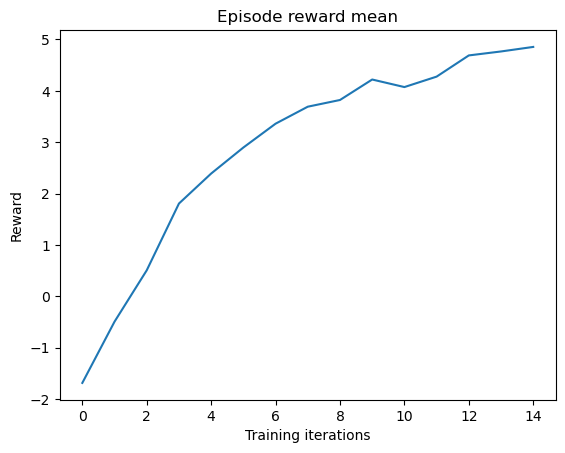

In [56]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.show()

In [58]:
with torch.no_grad():
    env.rollout(
        max_steps=max_steps,
        policy=policy,
        callback=lambda env, _: env.render(),
        auto_cast_to_device=False,
        break_when_any_done=False,
    )

ArgumentError: argument 2: <class 'TypeError'>: wrong type